# Анализ результатов A/B-тестирования интернет-магазина

Владельцы онлайн-магазина, специализирующегося на продаже спортивных товаров и товаров для здорового образа жизни, хотят расширить ассортимент. Но перед этим нужно решить одну проблему. Интерфейс онлайн-магазина слишком сложен для пользователей — об этом говорят отзывы.

Чтобы привлечь новых клиентов и увеличить число продаж, владельцы магазина разработали новую версию сайта и протестировали его на части пользователей. По задумке, это решение доказуемо повысит количество пользователей, которые совершат покупку.

Наша задача — провести оценку результатов A/B-теста. 

У нас в распоряжении:

* данные о действиях пользователей и распределении их на группы;
* техническое задание.

## Цели исследования



**Цели:** 
* Проверить корректность проведения A/B теста
* Проанализировать результаты A/B теста и проверить гипотезу

**Гипотеза эксперимента:** Упрощение интерфейса сайта приведёт к тому, что в течение семи дней после регистрации в системе конверсия зарегистрированных пользователей в покупателей увеличится как минимум на три процентных пункта.

**Ключевая метрика:** Коэффициент конверсии пользователей в покупку в течение 7 дней с момента регистрации.

**Нулевая гипотеза $H_0: \mu_{\text{A}} = \mu_{\text{B}}$: <br>** Доля пользователей, совершающих покупки на новом и старом интерфейсе сайта в течение 7 дней с момента регистрации, не различаются.

**Альтернативная гипотеза $H_1: \mu_{\text{A}} < \mu_{\text{B}}$: <br>** Доля пользователей, совершающих покупки в течение 7 дней с момента регистрации на новом интерфейсе сайта выше, чем доля пользователей, совершающих покупки на старом интерфейсе сайта за тот же промежуток времени.

### Описание данных



Данные участников тестов - **`ab_test_participants.csv`**: 

* **`user_id`** — идентификатор пользователя;
* **`group`** — группа пользователя;
* **`ab_test`** — название теста;
* **`device`** — устройство, с которого происходила регистрация.

События 2020 года - **`ab_test_events.csv`**:
* **`user_id`** — идентификатор пользователя;
* **`event_dt`** — дата и время события;
* **`event_name`** — тип события;
* **`details`** — дополнительные данные о событии.

Дополнительная информация по столбцу **`details`**:

***Числовые значения:***
* **`registration`** (регистрация) — стоимость привлечения клиента;
* **`purchase`** (покупка) — стоимость покупки.

***Текстовые значения:***
* **`ZONE_CODE00`** - None
* **`ZONE_CODE01`** - EU
* **`ZONE_CODE02`** - CIS
* **`ZONE_CODE03`** - EU, CIS
* **`ZONE_CODE04`** - APAC
* **`ZONE_CODE05`** - EU, APAC
* **`ZONE_CODE06`** - CIS, APAC
* **`ZONE_CODE07`** - EU, CIS, APAC
* **`ZONE_CODE08`** - N.America
* **`ZONE_CODE09`** - EU, N.America
* **`ZONE_CODE10`** - CIS, N.America
* **`ZONE_CODE11`** - EU, CIS, N.America
* **`ZONE_CODE12`** - APAC, N.America
* **`ZONE_CODE13`** - EU, APAC, N.America
* **`ZONE_CODE14`** - CIS, APAC, N.America
* **`ZONE_CODE15`** - EU, CIS, APAC, N.America


## 1. Загрузка данных и знакомство с ними


In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt

try:
    from matplotlib_venn import venn2
except:
    !pip install matplotlib-venn
    from matplotlib_venn import venn2
    
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

In [2]:
# Читаем датасет ab_test_participants.csv
participants = pd.read_csv('datasets/ab_test_participants.csv')

# Читаем датасет ab_test_events.csv
events = pd.read_csv('datasets/ab_test_events.csv', parse_dates=['event_dt'], low_memory=False)

In [3]:
# Выводим первые 5 строк датафрейма participants для ознакомления
participants.head()

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [4]:
# Выводим информацию о датафрейме participants
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [5]:
# Выведем уникальные значения категорийных параметров
print(f"Значения параметра 'ab_test':{participants['ab_test'].unique()}")
print(f"Значения параметра 'group': {participants['group'].unique()}")
print(f"Значения параметра 'device':{participants['device'].unique()}")

Значения параметра 'ab_test':['interface_eu_test' 'recommender_system_test']
Значения параметра 'group': ['B' 'A']
Значения параметра 'device':['Mac' 'Android' 'iPhone' 'PC']


In [6]:
# Проверим данные на наличие дублей
print(f"Количество дублей в датафрейме 'participants': {participants.duplicated().sum()}")

Количество дублей в датафрейме 'participants': 0


In [7]:
# Выводим первые 5 строк датафрейма events для ознакомления
events.head()

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [8]:
# Выводим информацию о датафрейме events
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


In [9]:
# Проверим данные на наличие дублей
print(f"Количество дублей в датафрейме 'events': {events.duplicated().sum()}")

Количество дублей в датафрейме 'events': 36318


In [10]:
# Удаляем дубли
events = events.drop_duplicates()

# Проверяем
print(f"Количество дублей в датафрейме 'events' после обработки: {events.duplicated().sum()}")

Количество дублей в датафрейме 'events' после обработки: 0


***При первичном знакомстве с датасетами данные выглядят полными и корректными. В датафреймме `events` удалено 36318 дублирующих строк.***

## 2. Оценка корректности проведения теста



**В датасете `ab_test_participants` выделим пользователей, участвующих в тесте, и проверим:**

* соответствие требованиям технического задания;
* равномерность распределения пользователей по группам теста;
* отсутствие пересечений с конкурирующим тестом (нет пользователей, участвующих одновременно в двух тестовых группах).

In [11]:
# Считаем количество уникальных пользователей в каждой из групп эксперимента
cnt_users_testgroup = participants[participants['ab_test'] == 'interface_eu_test'].groupby('group').agg({'user_id': 'nunique'}).reset_index()
cnt_users_testgroup.rename(columns={'user_id': 'count_users'}, inplace=True)
display(cnt_users_testgroup)
print(f"Всего пользователей в эксперименте: {cnt_users_testgroup['count_users'].sum()}")

,group,count_users
0,A,5383
1,B,5467


Всего пользователей в эксперименте: 10850


In [12]:
# Рассчитаем как сильно отличаются группы по количеству пользователей
diff_testgroup = 100 * (abs(cnt_users_testgroup.iloc[0, 1] - cnt_users_testgroup.iloc[1, 1]) / cnt_users_testgroup.iloc[0, 1])
print(f"Процентная разница в количестве пользователей в группах A и B составляет: {diff_testgroup:.2f}%")

Процентная разница в количестве пользователей в группах A и B составляет: 1.56%


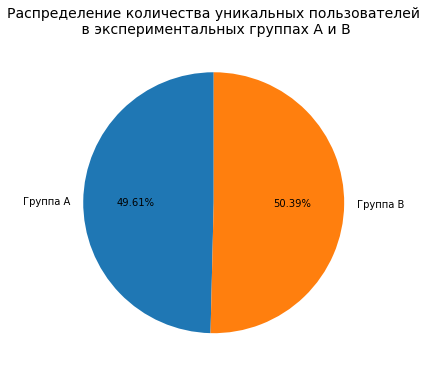

In [13]:
# Строим круговую диаграмму распределения экспериментальных групп
plt.figure(figsize=(8, 6))

plt.pie(cnt_users_testgroup['count_users'],
        labels=['Группа A', 'Группа B'],
        autopct='%.2f%%',
        startangle=90
       )
plt.title('Распределение количества уникальных пользователей\n в экспериментальных группах A и B', fontsize=14)
plt.show()

***Количество уникальных пользователей в обеих группах соизмеримо.***

**Проверим на отсутствие пересечений пользователей между группами целевого эксперимента и пересечений с конкурирующим экспериментом**

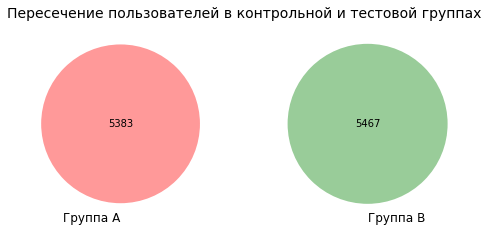

In [14]:
# Проверяем наличие пересечений между группами

# Сохраним значения user_id для каждой группы в отдельный массив
group_A = set(participants.loc[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'A'), 'user_id'])
group_B = set(participants.loc[(participants['ab_test'] == 'interface_eu_test') & (participants['group'] == 'B'), 'user_id'])

# Построим диаграмму Венна
plt.figure(figsize=(8,8))
venn2([group_A, group_B], set_labels=('Группа A', 'Группа B'))
plt.title("Пересечение пользователей в контрольной и тестовой группах", fontsize=14)
plt.show()

***Пересечений в группах целевого эксперимента не обнаружено.***

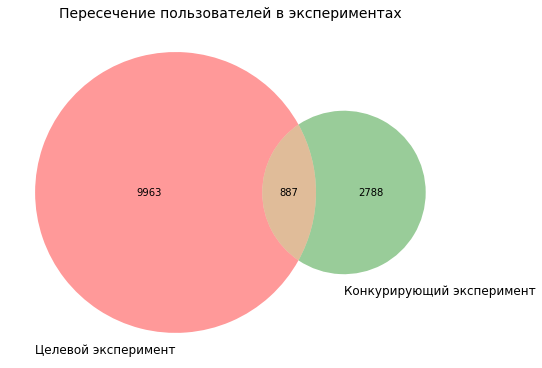

In [15]:
# Проверяем наличие пересечений целевого эксперимента с конкурирующим

# Сохраним значения user_id для каждого эксперимента в отдельный массив
test_1 = set(participants.loc[participants['ab_test'] == 'interface_eu_test', 'user_id'])
test_2 = set(participants.loc[participants['ab_test'] == 'recommender_system_test', 'user_id'])

# Построим диаграмму Венна
plt.figure(figsize=(8,8))
venn2([test_1, test_2], set_labels=('Целевой эксперимент', 'Конкурирующий эксперимент'))
plt.title("Пересечение пользователей в экспериментах", fontsize=14)
plt.show()

***Видим, что 887 пользователей попали в оба эксперимента, что может повлиять на результаты целевого эксперимента, поэтому этих пользователей стоит исключить.***

**Отфильтруем датасет по целевому эксперименту `interface_eu_test` и удалим пользователей, присутствующих в конкурирующем эксперименте `recommender_system_test`**

In [16]:
users_recommender_test = participants[participants['ab_test'] == 'recommender_system_test']['user_id'].unique()
participants_filter = participants[~participants['user_id'].isin(users_recommender_test)]

In [17]:
print(f"Количество пользователей в целевом эксперименте: {participants_filter['user_id'].nunique()}")

Количество пользователей в целевом эксперименте: 9963


**Проанализируем данные о пользовательской активности по таблице `ab_test_events`.**\
**Оставим только события, связанные с участвующими в целевом тесте пользователями.**

In [18]:
# Присоединим к датафрему "participants_filter" датафрейм "events" 
final_participants = participants_filter.merge(events, on='user_id', how='left')

In [19]:
# Проверяем результат
final_participants.head()

,user_id,group,ab_test,device,event_dt,event_name,details
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN


In [20]:
print(f"Количество уникальных пользователей: {final_participants['user_id'].nunique()}")

Количество уникальных пользователей: 9963


In [21]:
star_test = (final_participants['event_dt'].min())
finish_test = (final_participants['event_dt'].max())
duration_test = (finish_test - star_test).days
print(f"Продолжительность A/B теста(дней): {duration_test}")

Продолжительность A/B теста(дней): 24


**Определим горизонт анализа: рассчитаем время (лайфтайм) совершения события пользователем после регистрации и оставим только те события, которые были выполнены в течение первых семи дней с момента регистрации.**

In [22]:
# Выведем перечень доступных событий
list(final_participants['event_name'].unique())

['registration', 'login', 'product_page', 'product_cart', 'purchase']

In [23]:
# Находим дату регистрации для каждого пользователя
registration_times = final_participants[final_participants['event_name'] == 'registration'].groupby('user_id')['event_dt'].min().reset_index(name='reg_dt')

# Присоединяем к датафрейму final_participants
final_participants_rd = final_participants.merge(registration_times, on='user_id', how='left')

# Для каждого события рассчитываем продолжительность дней с даты регистрации
final_participants_rd['time_after_reg'] = (final_participants_rd['event_dt'] - final_participants_rd['reg_dt']).dt.days

# Оставляем только те события, которые происходили в течение 7 дней с даты регистрации
final_participants = final_participants_rd[final_participants_rd['time_after_reg'] < 7]

In [24]:
# Проверяем результат
final_participants.head(5)

,user_id,group,ab_test,device,event_dt,event_name,details,reg_dt,time_after_reg
0,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:31,registration,-2.38,2020-12-07 04:37:31,0
1,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:49,login,NaN,2020-12-07 04:37:31,0
2,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:37:57,login,NaN,2020-12-07 04:37:31,0
3,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-07 04:38:54,login,NaN,2020-12-07 04:37:31,0
4,0002CE61FF2C4011,B,interface_eu_test,Mac,2020-12-08 22:15:35,login,NaN,2020-12-07 04:37:31,1


In [25]:
print(f"Количество дней в когорте: {final_participants['time_after_reg'].nunique()}")

Количество дней в когорте: 7


In [26]:
print(f"Количество уникальных пользователей: {final_participants['user_id'].nunique()}")

Количество уникальных пользователей: 9963


**Оценим достаточность выборки для получения статистически значимых результатов A/B-теста.**

**Заданные параметры:**
* базовый показатель конверсии — 30%,
* мощность теста — 80%,
* достоверность теста — 95%.

In [27]:
# Задаём параметры
alpha = 0.05   # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03   # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")
print(f"Количество пользователей в группе A: {final_participants[final_participants['group'] == 'A']['user_id'].nunique()}")
print(f"Количество пользователей в группе B: {final_participants[final_participants['group'] == 'B']['user_id'].nunique()}")

Необходимый размер выборки для каждой группы: 3761
Количество пользователей в группе A: 4952
Количество пользователей в группе B: 5011


***Размер выборки каждой группы достаточен для получения статистически значимых результатов A/B теста***

**Рассчитаем для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.**

In [28]:
# Рассчитываем для каждой группы количество покупающих и общее количество пользователей
cr_users = final_participants.groupby('group').agg(
    total_users = ('user_id', 'nunique'),
    buying_users = ('user_id', lambda x: x[final_participants.loc[x.index, 'event_name'] == 'purchase'].nunique())
).reset_index()

# Считаем конверсию
cr_users['cr'] = round(cr_users['buying_users'] / cr_users['total_users'] * 100, 2)

In [29]:
# Выводим результат
display(cr_users)

,group,total_users,buying_users,cr
0,A,4952,1377,27.81
1,B,5011,1480,29.54


In [30]:
diff_cr = round(cr_users.iloc[1, 3] - cr_users.iloc[0, 3], 2)
print(f"Конверсия в тестовой группе превышает контрольную на {diff_cr} процентных пункта")

Конверсия в тестовой группе превышает контрольную на 1.73 процентных пункта


**Предварительные выводы об изменении пользовательской активности в тестовой группе по сравнению с контрольной**

***Контрольная группа (A):***
* Зарегистрированных пользователей: 4952
* Пользователей, совершивших покупку: 1377
* Конверсия: 27.81%

***Тестовая группа (B):***
* Зарегистрированных пользователей: 5011
* Пользователей, совершивших покупку: 1480
* Конверсия: 29,54%

***Про результатам проведенного A/B теста конверсия в тестовой группе увеличилась на 1.73 процентных пункта***

## 3. Оценка результатов A/B-тестирования

**Проверим изменение конверсии статистическим тестом. Так, как ключевой метрикой A/B теста является коэффициент конверсии, то подходящим статистическим тестом будет Z-тест пропорций.**

In [31]:
# Проверим, выполняется ли предпосылка Z-теста пропорций о достаточном размере выборок

n_a, n_b = cr_users.iloc[0, 1], cr_users.iloc[1, 1]
m_a, m_b = cr_users.iloc[0, 2], cr_users.iloc[1, 2]
p_a = m_a/n_a
p_b = m_b/n_b

if (p_a * n_a > 10) and ((1-p_a) * n_a > 10) and (p_b * n_b > 10) and ((1-p_b) * n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется!')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется!')

Предпосылка о достаточном количестве данных выполняется!


In [32]:
# Устанавливаем уровень значимости
alpha = 0.05

# Проверяем гипотезу
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller'
)

if p_value_ztest < alpha:
    print(f'Значение p-value = {p_value_ztest:.10f} < {alpha}')
    print(f'Статистика Z-критерия = {stat_ztest:.10f}')
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print(f'Значение p-value = {p_value_ztest:.10f} > {alpha}')
    print(f'Статистика Z-критерия = {stat_ztest:.10f}')
    print('Не получилось отвергнуть нулевую гипотезу')

Значение p-value = 0.0282625472 < 0.05
Статистика Z-критерия = -1.9069651971
Отвергаем нулевую гипотезу в пользу альтернативной


## 4. Выводы

Для оценки результатов A/B теста был применен Z-тест пропорций, т.к. сравнивали коэффициент конверсии двух групп.
Уровень значимости установлен в размере 5% (a = 0.05).

**Результат статистического теста:**\
По результатам Z-теста пропорций мы получили p-value равный 0.028, что меньше установленного уровня значимости (0,05), следовательно есть статистическое основание отклонить нулевую гипотезу в пользу альтернативной.

**Вывод:**\
Гипотеза заказчика имеет частичное подтверждение. Есть статистическое основание полагать, что упрощение интерфейса сайта приводит к увеличению конверсии пользователей, совершающих покупку в течение 7 дней с даты регистрации. Но по результатам данного эксперимента мы увидели дельту коэффициента конверсии в размере 1,73 процентных пункта, что не удовлетворяет бизнес-цели заказчика.

**Рекомендации:**\
Рекомендуется повторно провести A/B тестирование с увеличением наблюдений и продолжительностью теста. 
